# Extracting Deep Representations

In this tutorial we will train a neural network for a classification task and we will extract features from various levels of the network. These features will be evaluated in two different setups: 

1. **in-domain evaluation**, where test (unknown) data from the *same* domain will be used for the evaluation,
2. **out-of-domain evaluation**, where data from a *different* domain will be used for the evaluation.

As expected, the most discriminative features leads to the best *in-domain* precision, but they are not always the best for generic retrieval tasks (*out-of-domain* evaluation)!


First, let's load the dataset. We will be using the well-known CIFAR-10 dataset.

In [1]:
import keras
from keras.datasets import cifar10
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Next, we appropriately split the dataset into in-domain/out-of-domain and train/test splits. The last 6 classes are used for the in-domain training/testing, while the rest 4 classes are used for the out-of-domain evaluation.

In [2]:
# Split the dataset into in-domain and out-of-domain data
train_idx_out = np.logical_or(y_train==0, np.logical_or(y_train==1, np.logical_or(y_train==2, y_train==3)))[:, 0]
test_idx_out = np.logical_or(y_test==0, np.logical_or(y_test==1,  np.logical_or(y_test==2, y_test==3)))[:, 0]

x_train_in, y_train_in = x_train[np.logical_not(train_idx_out)], y_train[np.logical_not(train_idx_out)]
x_test_in, y_test_in = x_test[np.logical_not(test_idx_out)], y_test[np.logical_not(test_idx_out)]

# Out-of-domain
x_train_out, y_train_out = x_train[train_idx_out], y_train[train_idx_out]
x_test_out, y_test_out = x_test[test_idx_out], y_test[test_idx_out]

print("Train data (in): ", x_train_in.shape, y_train_in.shape)
print("Test data (in): ",  x_test_in.shape, y_test_in.shape)
print("Train data (out): ", x_train_out.shape, y_train_out.shape)
print("Test data (out): ", x_test_out.shape, y_test_out.shape)


Train data (in):  (30000, 32, 32, 3) (30000, 1)
Test data (in):  (6000, 32, 32, 3) (6000, 1)
Train data (out):  (20000, 32, 32, 3) (20000, 1)
Test data (out):  (4000, 32, 32, 3) (4000, 1)


Let's examine a few images to ensure that everything is ok!

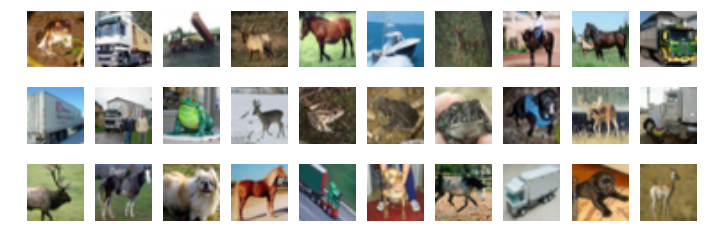

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot some in-domain data
plt.figure(figsize=(12, 4))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(x_train_in[i], interpolation="bilinear")
    plt.axis('off')


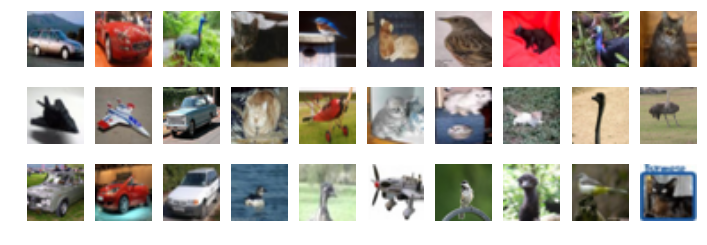

In [4]:
# Plot some out-of-domain data
plt.figure(figsize=(12, 4))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(x_train_out[i], interpolation="bilinear")
    plt.axis('off')


Let's train our classification model! But, first we have to preprocess our data.

In [5]:
# Normalize the data
x_train_out = x_train_out/255.0
x_test_out = x_test_out/255.0
x_train_in = x_train_in/255.0
x_test_in = x_test_in/255.0

# Transform the labels using one-hot encoding
y_train_out = keras.utils.to_categorical(y_train_out, 10)
y_test_out = keras.utils.to_categorical(y_test_out, 10)
y_train_in = keras.utils.to_categorical(y_train_in, 10)
y_test_in = keras.utils.to_categorical(y_test_in, 10)


Also, we have to define our model. We use a simple convolutional architecture.

In [6]:
from keras.models import Sequential
import keras.optimizers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Use 10 neurons to make our life a bit easier
model.add(Dense(10))
model.add(Activation('softmax'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

We are now ready to train the model!

In [8]:
opt = keras.optimizers.adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [9]:
model.fit(x_train_in, y_train_in, batch_size=128,  epochs=20,  validation_data=(x_test_in, y_test_in),
              shuffle=True, verbose=2)

Train on 30000 samples, validate on 6000 samples
Epoch 1/20
 - 6s - loss: 1.2417 - acc: 0.5110 - val_loss: 0.9621 - val_acc: 0.6495
Epoch 2/20
 - 4s - loss: 0.8638 - acc: 0.6784 - val_loss: 0.7011 - val_acc: 0.7447
Epoch 3/20
 - 4s - loss: 0.7026 - acc: 0.7441 - val_loss: 0.6193 - val_acc: 0.7740
Epoch 4/20
 - 4s - loss: 0.6042 - acc: 0.7817 - val_loss: 0.5436 - val_acc: 0.7948
Epoch 5/20
 - 4s - loss: 0.5400 - acc: 0.8065 - val_loss: 0.5073 - val_acc: 0.8203
Epoch 6/20
 - 4s - loss: 0.4863 - acc: 0.8259 - val_loss: 0.4746 - val_acc: 0.8268
Epoch 7/20
 - 4s - loss: 0.4377 - acc: 0.8442 - val_loss: 0.4798 - val_acc: 0.8273
Epoch 8/20
 - 4s - loss: 0.4076 - acc: 0.8539 - val_loss: 0.4134 - val_acc: 0.8580
Epoch 9/20
 - 4s - loss: 0.3809 - acc: 0.8627 - val_loss: 0.4177 - val_acc: 0.8533
Epoch 10/20
 - 4s - loss: 0.3514 - acc: 0.8759 - val_loss: 0.3632 - val_acc: 0.8750
Epoch 11/20
 - 4s - loss: 0.3256 - acc: 0.8842 - val_loss: 0.3650 - val_acc: 0.8767
Epoch 12/20
 - 4s - loss: 0.3205 - a

Also, lets evaluate the model using the test dataset! 

In [10]:
print("Test accuracy = %3.3f"%(model.evaluate(x_test_in, y_test_in)[1]))

6000/6000 [==============================] - 1s 101us/step
Test accuracy = 0.889


88.9% accuracy! Not bad for such as naive architecture trained only for 20 epochs. 

Now we are ready to evaluate of model extracting features from the following layers: *flatten_1* (convolutional features), *dense_1* (features from the first fully connected layers), *dense_2* (features from the second fully connected layer) and *activation_6* (features directly from the classification layer*.

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


In-domain (layer: flatten_1) mAP:46.6675 
Outof--domain (layer: flatten_1) mAP:45.4094 


100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


In-domain (layer: dense_1) mAP:66.5545 
Outof--domain (layer: dense_1) mAP:50.6019 


100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


In-domain (layer: dense_2) mAP:76.7176 
Outof--domain (layer: dense_2) mAP:47.5424 


100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


In-domain (layer: activation_6) mAP:92.3987 
Outof--domain (layer: activation_6) mAP:46.8482 


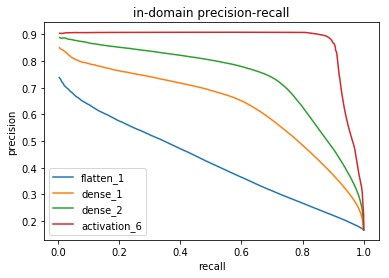

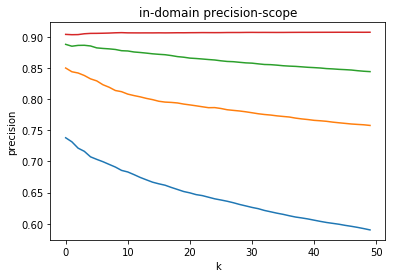

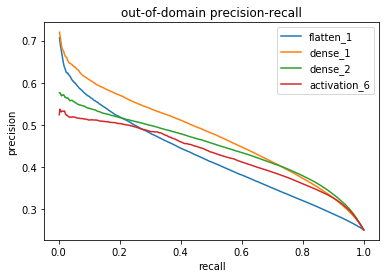

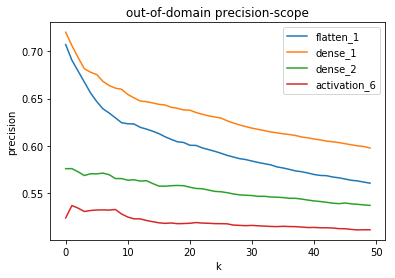

In [12]:
from evaluation import evaluate_database

# Use only n_samples for the evaluation (to increase the evaluation speed)
n_samples = 1000


for i in range(123, 127):
     plt.figure(i)
     plt.clf()

layers = ['flatten_1', 'dense_1', 'dense_2', 'activation_6']
for layer_name in layers:
    representation_model = keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feat_train_in = representation_model.predict(x_train_in[:n_samples])
    feat_test_in = representation_model.predict(x_test_in[:n_samples])
    
    feat_train_out = representation_model.predict(x_train_out)
    feat_test_out = representation_model.predict(x_test_out)
    
    
    m_ap, precision, recall, precision_at_recall_levels, ap, hamming_2_prec = \
        evaluate_database(feat_train_in[:n_samples], np.argmax(y_train_in[:n_samples], axis=1),  
                          feat_test_in[:n_samples], np.argmax(y_test_in[:n_samples], axis=1), metric='cosine' )
    
    print("In-domain (layer: %s) mAP:%3.4f "%(layer_name, 100*m_ap))
    plt.figure(123)
    plt.plot(recall, precision)

    plt.figure(124)
    plt.plot(np.arange(50), precision[:50], )
    
    
    m_ap, precision, recall, precision_at_recall_levels, ap, hamming_2_prec = \
        evaluate_database(feat_train_out[:n_samples], np.argmax(y_train_out[:n_samples], axis=1),  
                          feat_test_out[:n_samples], np.argmax(y_test_out[:n_samples], axis=1), metric='cosine' )
    
    print("Out-of-domain (layer: %s) mAP:%3.4f "%(layer_name, 100*m_ap))
    plt.figure(125)
    plt.plot(recall, precision)

    plt.figure(126)
    plt.plot(np.arange(50), precision[:50], )


# Make the plots a bit prettier

plt.figure(123)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('in-domain precision-recall')
plt.legend(layers)

plt.figure(124)
plt.xlabel('k')
plt.ylabel('precision')
plt.title('in-domain precision-scope')

plt.figure(125)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('out-of-domain precision-recall')
plt.legend(layers)

plt.figure(126)
plt.xlabel('k')
plt.ylabel('precision')
plt.title('out-of-domain precision-scope')


plt.legend(layers)



As expected, the features extracted from the deeper layers of the network have greater discriminative power, leading to higher retrieval precision. On the other hand, the less discriminative features extracted from the first dense layer, leads to the best precision in the out-of-domain evaluation.

We can also verify that we indeed obtain meaningful results!

In [67]:
representation_model = keras.Model(inputs=model.input, outputs=model.get_layer('dense_1').output)
feat_train_in = representation_model.predict(x_train_in[:1000])
feat_test_in = representation_model.predict(x_test_in[:100])

In [68]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=30, algorithm='brute', metric='cosine')
nn.fit(feat_train_in)
distances, idx = nn.kneighbors([feat_test_in[10]])
idx = idx[0]

Query image:

(-0.5, 31.5, 31.5, -0.5)

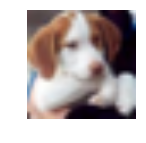

In [69]:
# Plot some out-of-domain data
plt.figure(figsize=(2, 2))
plt.imshow(x_test_in[10], interpolation="bilinear")
plt.axis('off')

Results:

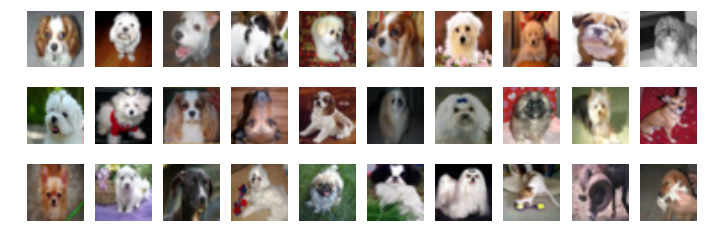

In [70]:
plt.figure(figsize=(12, 4))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(x_train_in[idx[i]], interpolation="bilinear")
    plt.axis('off')
    


Also, let's examine the distances for each of the retrieved images:

In [71]:
print(distances)

[[0.10783166 0.12228179 0.1243248  0.12842488 0.12886667 0.13381428
  0.13424045 0.13754797 0.13796932 0.14213604 0.14520144 0.1490798
  0.14987743 0.1511432  0.15198523 0.15456557 0.1563834  0.15744972
  0.15777075 0.15911913 0.15967417 0.16096663 0.16261357 0.16444927
  0.1652171  0.16559017 0.16625905 0.1669085  0.17184854 0.17362261]]


Use a less discriminative representation:

(-0.5, 31.5, 31.5, -0.5)

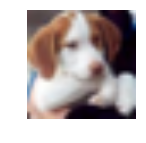

In [74]:
representation_model = keras.Model(inputs=model.input, outputs=model.get_layer('flatten_1').output)
feat_train_in = representation_model.predict(x_train_in[:1000])
feat_test_in = representation_model.predict(x_test_in[:100])

nn = NearestNeighbors(n_neighbors=30, algorithm='brute', metric='cosine')
nn.fit(feat_train_in)
distances, idx = nn.kneighbors([feat_test_in[10]])
idx = idx[0]

# Plot some out-of-domain data
plt.figure(figsize=(2, 2))
plt.imshow(x_test_in[10], interpolation="bilinear")
plt.axis('off')

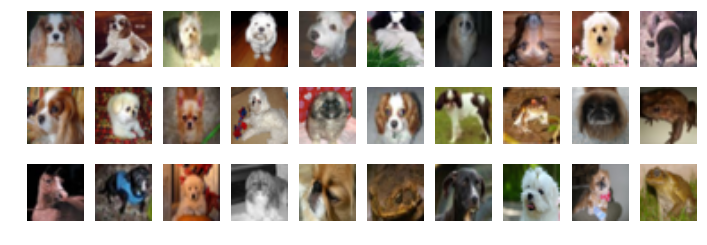

In [75]:
plt.figure(figsize=(12, 4))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(x_train_in[idx[i]], interpolation="bilinear")
    plt.axis('off')

Did you notice an interesting pattern?